# SVM with Docking Scores

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [2]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns

## Ensemble Docking con ligandos CSAR
- #### 111 ligandos
    - 27 Activos
- #### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [3]:
def open_results(path, column_to_drop, active_label='Active'):
    '''Function to load VS results from path file. It returns X and y ndarrays.'''
    path_file = os.path.join(*path.split('/'))
    df_results = pd.read_csv(path_file, index_col=0)
    y_ = pd.Series(df_results[column_to_drop] == active_label, dtype = int) # Setting y_true
    X_ = df_results.drop([column_to_drop], axis = 1) # Setting X
    return X_, y_

In [4]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = \
open_results(path = '../data/docking_scores/vs_docking_crys_ensemble_VINARDO.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dksc_CSAR", X_dksc_CSAR.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_CSAR, y_dkef_CSAR = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_CSAR_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dkef_CSAR", X_dkef_CSAR.shape)

Dims X_dksc_CSAR (111, 402)
Dims X_dkef_CSAR (111, 402)


## Ensemble Docking con ligandos DUD (2006)
- ### 2146 ligandos
    - 72 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [5]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = \
open_results(path = '../data/docking_scores/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DUD", X_dksc_DUD.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_DUD, y_dkef_DUD = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_DUD2006_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DUD", X_dkef_DUD.shape)

Dims X_dksc_DUD (2146, 402)
Dims X_dkef_DUD (2146, 402)


## Ensemble Docking con ligandos DEKOIS 2.0
- ### 1240 ligandos
    - 40 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [6]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DEKOIS, y_dksc_DEKOIS = open_results(
    path = '../data/docking_scores/vs_dk_CRYS_402_DEKOIS_VINARDO_docking_score.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DEKOIS", X_dksc_DEKOIS.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_DEKOIS, y_dkef_DEKOIS = \
open_results(
    path = '../data/docking_scores/vs_dk_CRYS_402_DEKOIS2_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DEKOIS", X_dkef_DEKOIS.shape)

Dims X_dksc_DEKOIS (1240, 402)
Dims X_dkef_DEKOIS (1240, 402)


In [7]:
# Finally we create adictionary that we will use to combine different approaches
scores_dic = {'CSAR': {'Dk_sc':   {'X': X_dksc_CSAR, 'y': y_dksc_CSAR}, 
                       'Dk_lef':  {'X': X_dkef_CSAR, 'y': y_dkef_CSAR} },
              'DUD':  {'Dk_sc':   {'X': X_dksc_DUD,  'y': y_dksc_DUD}, 
                       'Dk_lef':  {'X': X_dkef_DUD,  'y': y_dkef_DUD} },
              'DEKOIS': {'Dk_sc': {'X': X_dksc_DEKOIS,  'y': y_dksc_DEKOIS}, 
                       'Dk_lef':  {'X': X_dkef_DEKOIS,  'y': y_dkef_DEKOIS} },
             }

In [8]:
# Create the ranked versions
import copy
scores_copy = copy.deepcopy(scores_dic)

for dataset in scores_copy.keys():
    for score in scores_copy[dataset]:
        rk_name = 'Rk' + score[2:]
        scores = scores_copy[dataset][score]
        scores_dic[dataset][rk_name] = {'X': scores['X'].rank(), 'y': scores['y']}
        

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, f1_score

In [93]:
def train_model(X_train, y_train, estimator, estimator_params = None,
               scoring = 'roc_auc', k_folds = 5, standarize = True, **kwargs):
    '''
     1) Pipeline is created, and will perform StandarScaler. More steps can be added later.
     # pipe args is a list of tuples initialized with one element; the estimator.
     # If standarize = true it adds StandardScaler at the bigining of the pipe.
    '''
    pipe_args = [("estimator", estimator(**kwargs))]
    if standarize:
        pipe_args.insert(0, ("scaler", StandardScaler()))
    pipe = Pipeline(pipe_args)
    '''
    2) The specific hyperparameters of the selected stimator are given, 
    we will parse them to the gridSearch instance.
    '''
    if estimator_params != None:
        params = {}
        for key, value in estimator_params.items():
            params['estimator__'+key] = value
    '''
    3) Grid search cross validation for turning the optimal parameters, 
    it takes the pipeline object. GridSearch performs k-fold cross validation, 
    and uses the given scoring method to validate each set.
    '''
    grid = GridSearchCV(estimator = pipe, param_grid = params, 
                        cv = k_folds, scoring = scoring,
                        n_jobs = 6, refit=True)
    '''SVC training through GridSearch object'''
    grid.fit(X_train, y_train)
    '''Return the trained estimator'''
    return(grid)

def eval_model(model, X_test, y_test):
    '''
    1) Predictions and evaluation on the Test set
    - Scaling and prediction of X_train using the best model found by grid
    '''
    y_prob  = model.predict_proba(X_test)[:,1] # Predicted prob values for X_test
    #y_score = model.decision_function(X_test) 
    y_pred  = model.predict(X_test) # predicted values
    '''Returns the y_score values and the lnear_SVC object'''
    return(y_prob)

### model wrapper

In [90]:
def train_wrapper(train_key, list_of_scores, estimator,
                  scores_dic = scores_dic, selected_features = None, **kwargs):
    ''''''
    trained_models = {}
    for score in list_of_scores:
        if selected_features is None:
            X_train = scores_dic[train_key][score]['X']
        else:
            X_train = scores_dic[train_key][score]['X'][selected_features]
        y_train = scores_dic[train_key][score]['y']
        name = F'{score}'
        trained_models[name] = train_model(X_train, y_train, estimator, **kwargs)
    return(trained_models)
    
def eval_wrapper(trained_model, test_keys, list_of_scores,
                  scores_dic = scores_dic, **kwargs):
    model_results = {}
    for test_key in test_keys:
        y_preds = {}
        for score in list_of_scores:
            X_test  = scores_dic[test_key][score]['X']
            y_test  = scores_dic[test_key][score]['y']
            name = F'{test_key}-{score}'
            y_preds[name] = eval_model(trained_model[score], X_test, y_test)
        # Invoke PlotMetric Class
        model_results[test_key] = PlotMetric(y_true = y_test, y_pred_dict = y_preds, **kwargs)
    return(model_results)

def plot_predict_results(title, predictions, train_key, plot_rankings = True, plot_nef = False):
    n_rows = 2 if plot_nef else 1
    plt.figure(figsize=(14, 7*n_rows))
    for i, test_set in enumerate(test_keys):
        plt.subplot(F'{n_rows}2{i+1}')
        predictions[test_set].plot_roc_auc(F'{title}:\n{train_key} train, {test_set} test', 
                                     show_by_itself = False, fontsize = 'small')
        if plot_nef:
            plt.subplot(F'{n_rows}2{i+3}')
            predictions[test_set].plot_ef_auc('', method = 'normalized', max_chi = 0.2, 
                                         show_by_itself = False, fontsize = 'small')
    plt.show()
    if plot_rankings:
        for test_set in test_keys:
            predictions[test_set].plot_actives_distribution(add_to_title = test_set, 
                                                                max_position_to_plot=100)
            


### SVM Lineal

Model for Dk_sc:
	Best parameters: {'estimator__C': 0.1}
	Train set accuracy: 0.988
Model for Dk_lef:
	Best parameters: {'estimator__C': 0.1}
	Train set accuracy: 0.994


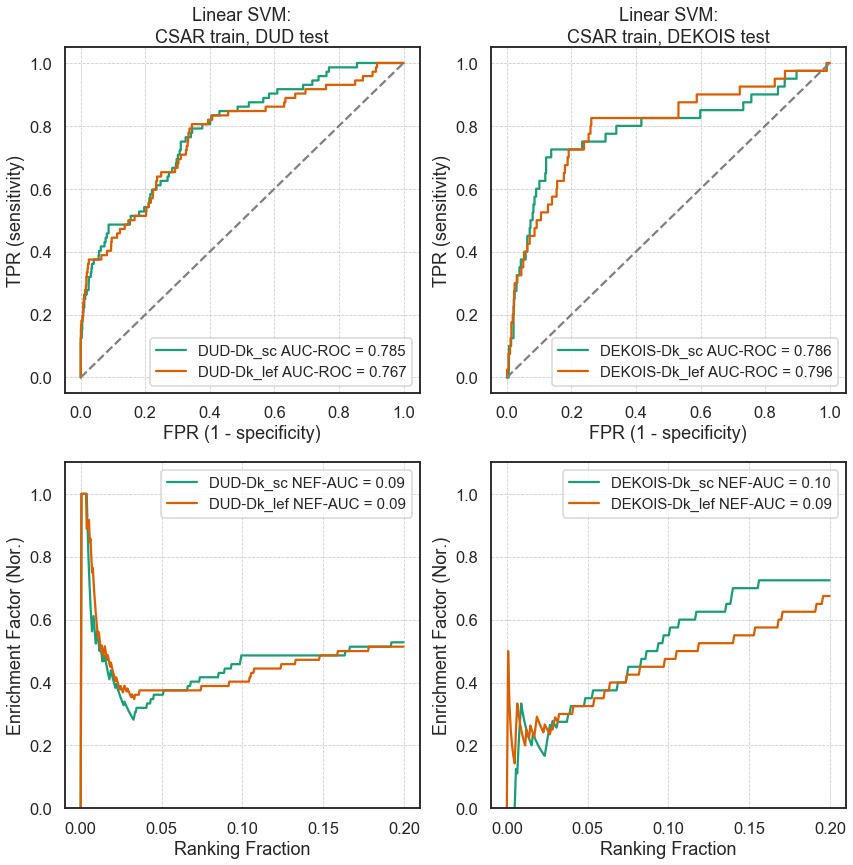

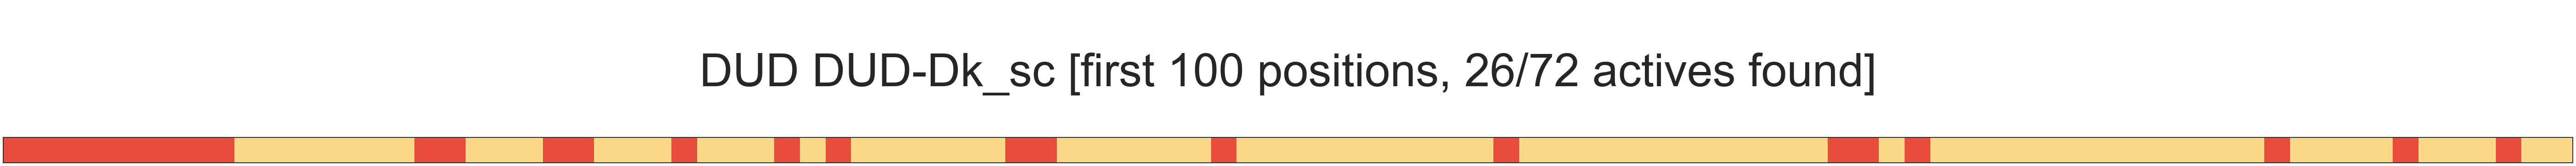

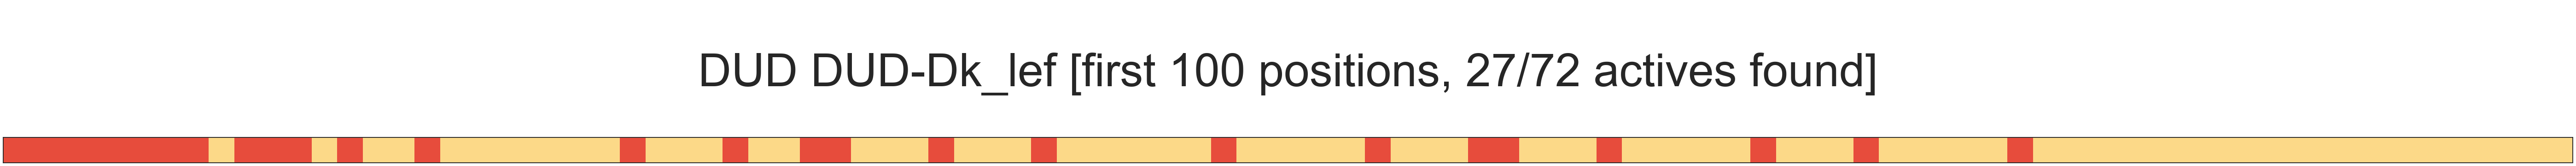

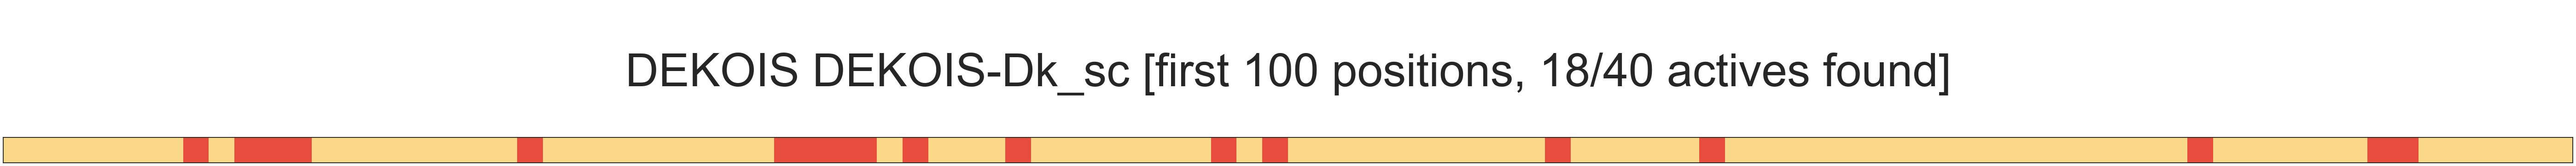

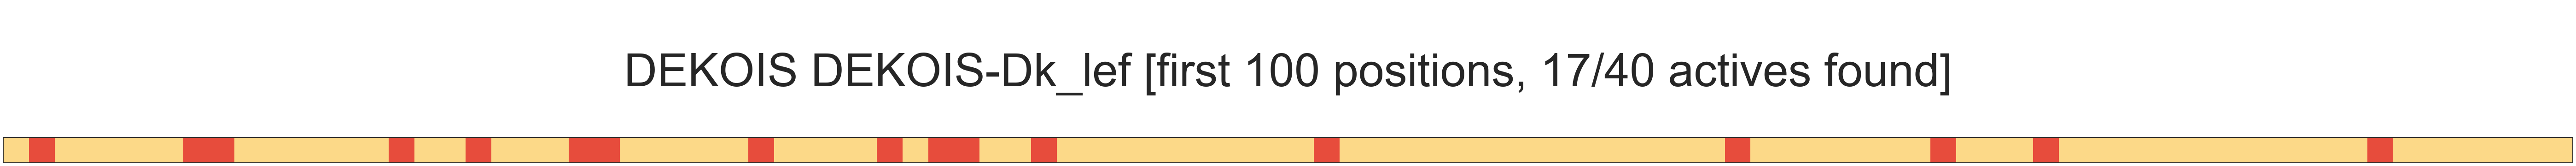

In [91]:
# Params to eval through grid search
svc_params = {'C': np.geomspace(0.1, 100, 4)}
# IMPORTANT: The following code trains as many models as the the number of elements in list_of_scores
list_of_scores = ['Dk_sc', 'Dk_lef']
# In this case, one model will be train for CSAR-Dk_sc and a different model for CSAR-Dk_leff

# The dataset that will be used for trining the model
train_key = 'CSAR'
# The name of the datasets which will be used for  testing
test_keys = ['DUD', 'DEKOIS']

# Training phase: The algorithm only 'sees' the train_key set
svm = SVC # Intance the estimator to be used
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_params = svc_params,
                        # kwargs exclusive for SVC
                        kernel = 'linear', probability = True)
# Parameters used
for name, model in svm_lineal.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = True)

## SVC RBF

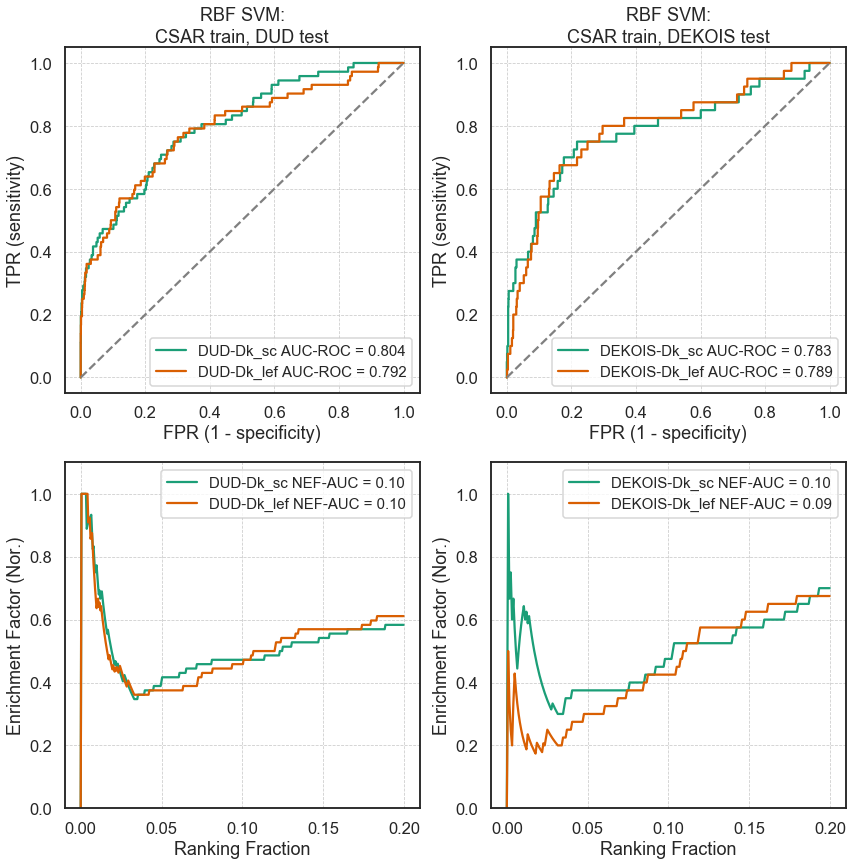

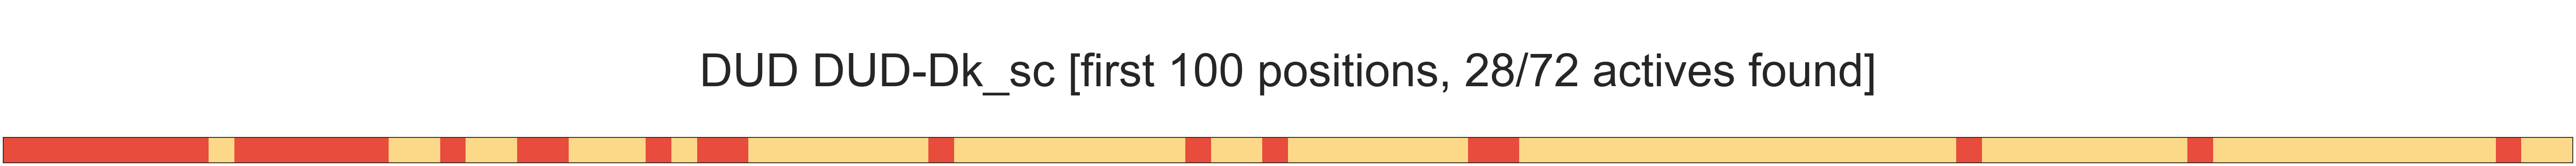

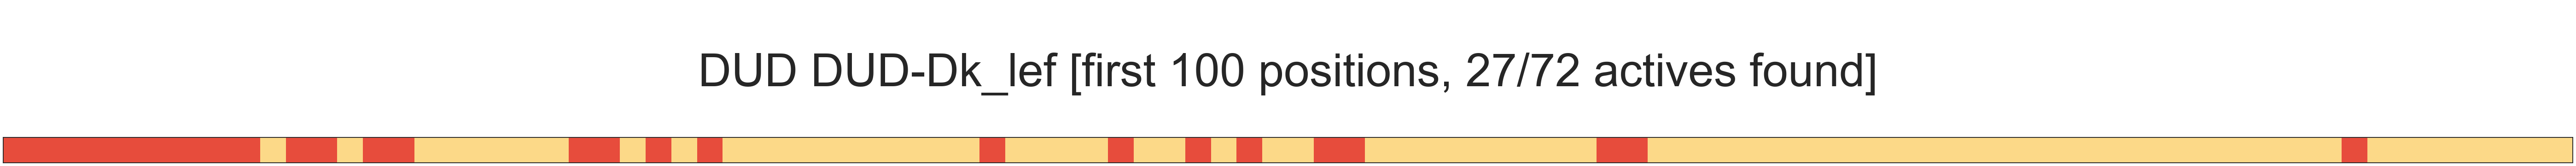

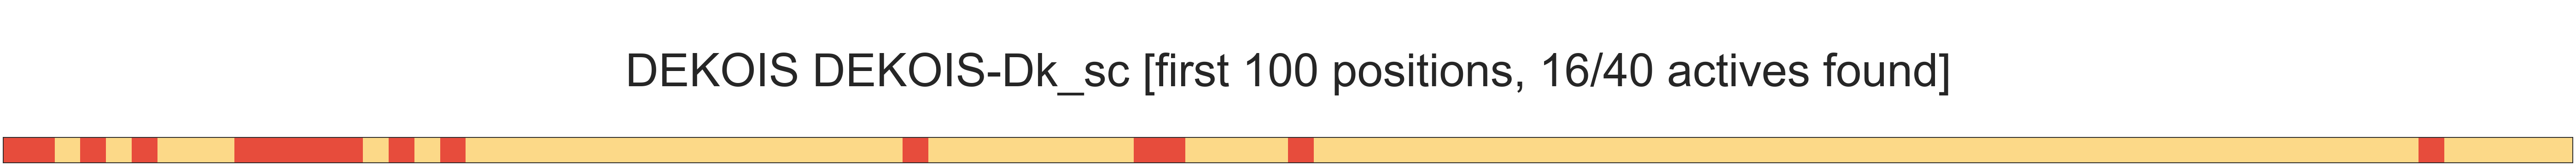

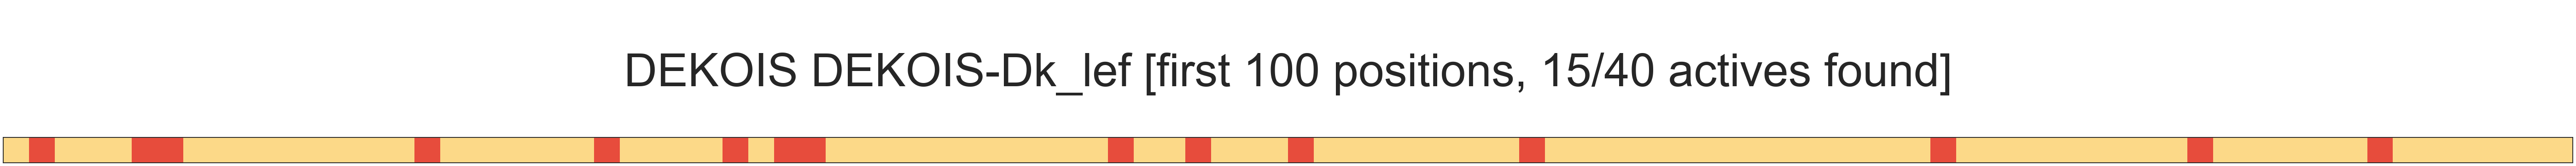

In [81]:
svc_params = {'gamma': [0.001, 0.01, 0.1, 1, 10], 'C': np.geomspace(0.1, 100, 4)}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
svm = SVC
svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_params = svc_params,
                        kernel = 'rbf', probability = True)

# Evaluation
svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = True)

### Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Model for Dk_sc:
	Best parameters: {'estimator__C': 0.001, 'estimator__penalty': 'none', 'estimator__solver': 'lbfgs'}
	Train set accuracy: 0.984
Model for Dk_lef:
	Best parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
	Train set accuracy: 0.992


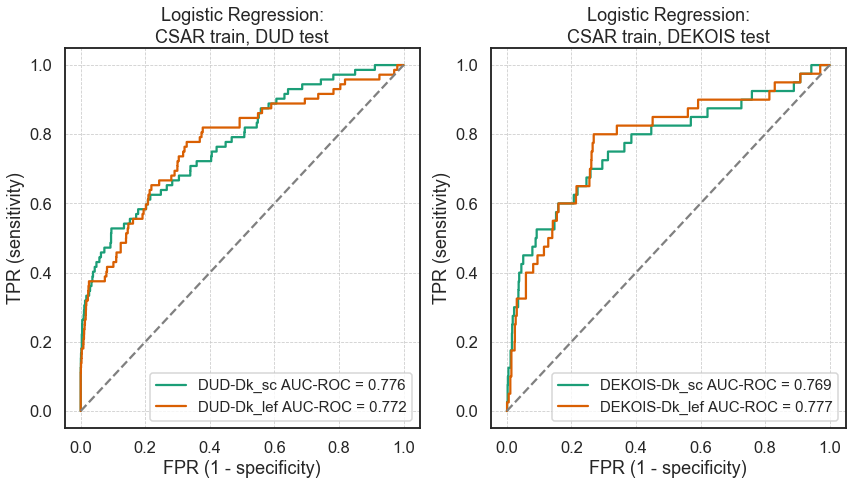

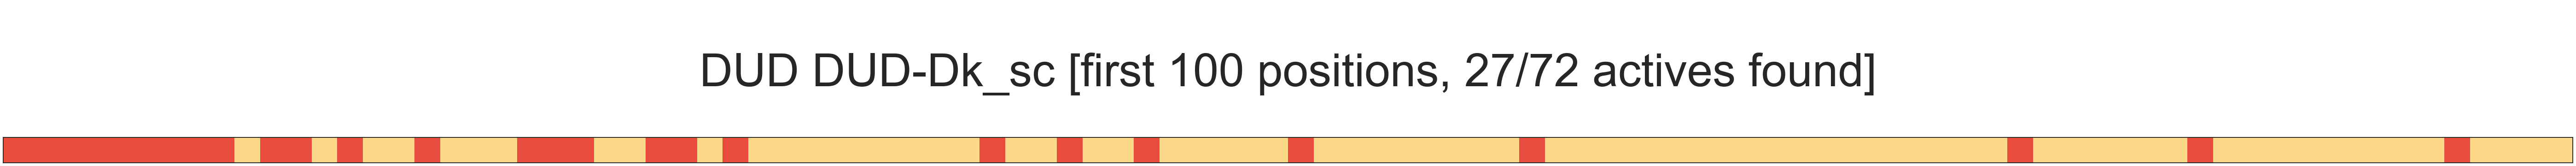

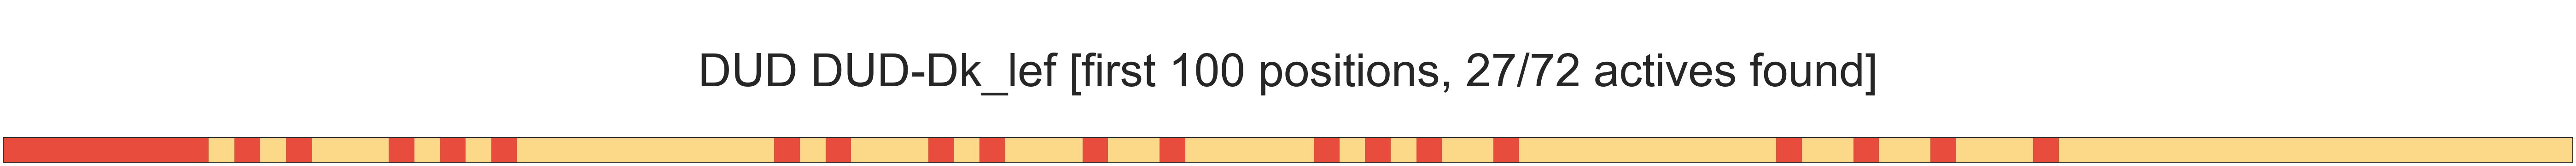

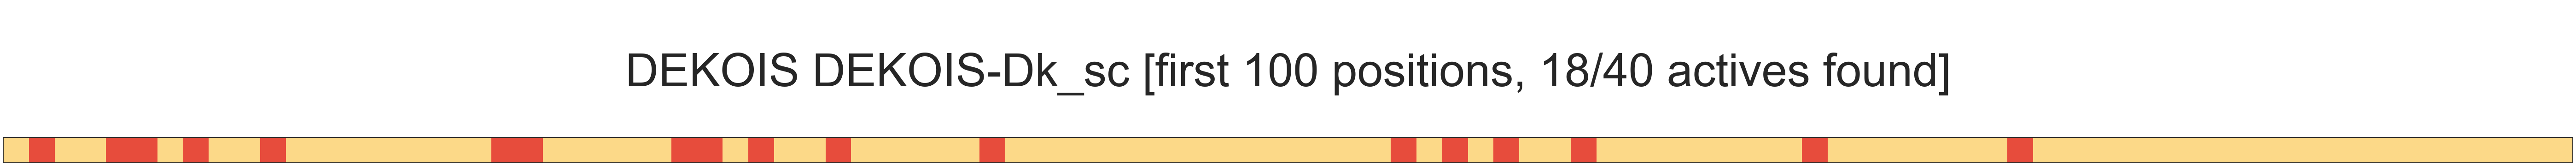

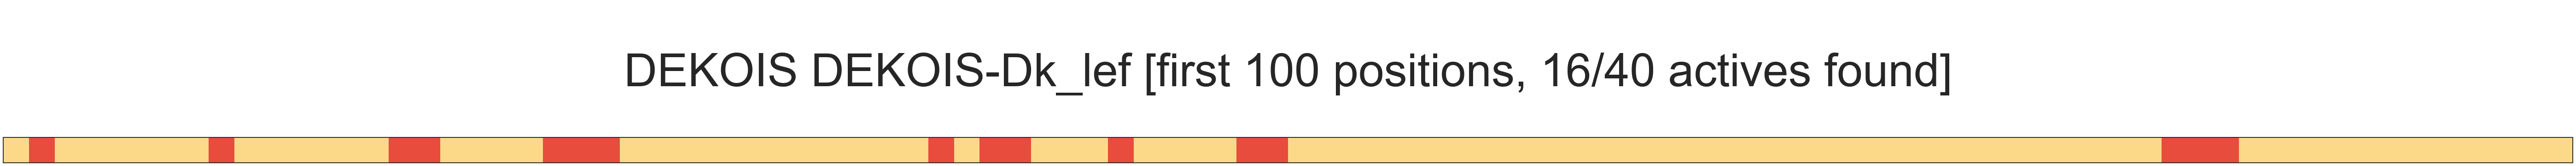

In [83]:
lg_params = {'C': [0.001, 0.01, 0.1], 'penalty': ['l1', 'l2', 'none'], 'solver': ['lbfgs', 'liblinear']}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
LG = LogisticRegression
lg_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= LG, estimator_params = lg_params,
                        )

# Parameters used
for name, model in lg_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
lg_clf_pred = eval_wrapper(trained_model = lg_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Logistic Regression', predictions = lg_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

## Decision Tree

In [84]:
from sklearn.tree import DecisionTreeClassifier

Model for Dk_sc:
	Best parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 3}
	Train set accuracy: 0.817
Model for Dk_lef:
	Best parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 2}
	Train set accuracy: 0.762


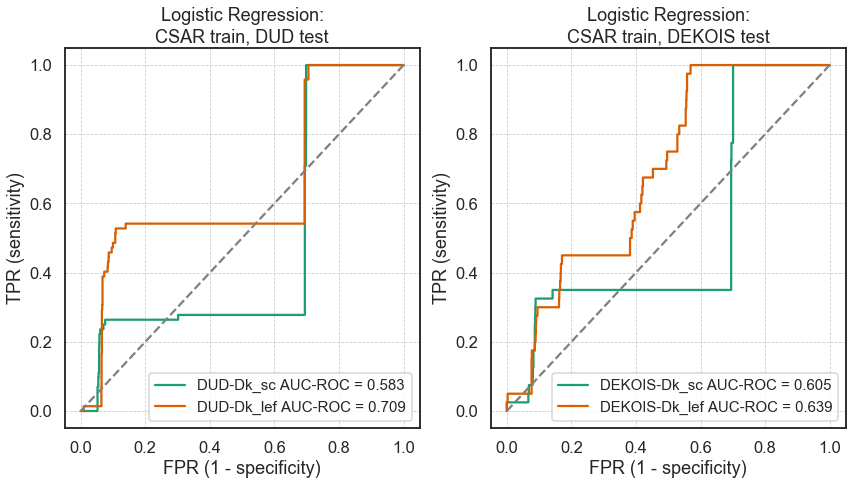

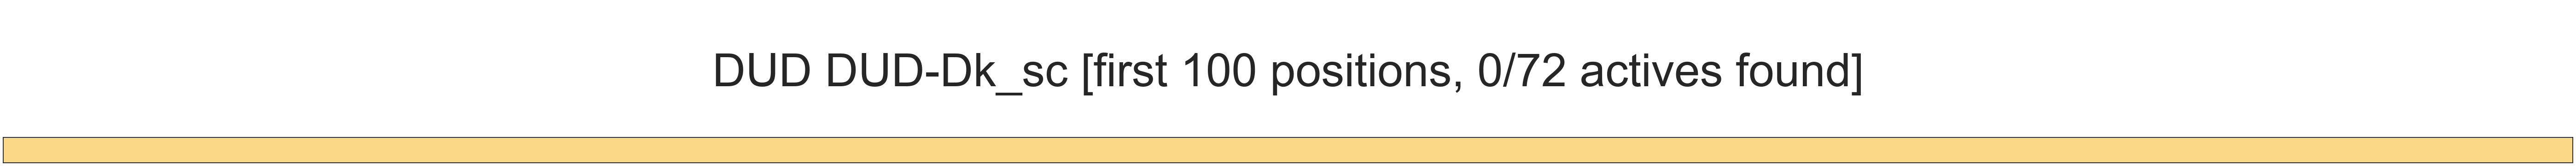

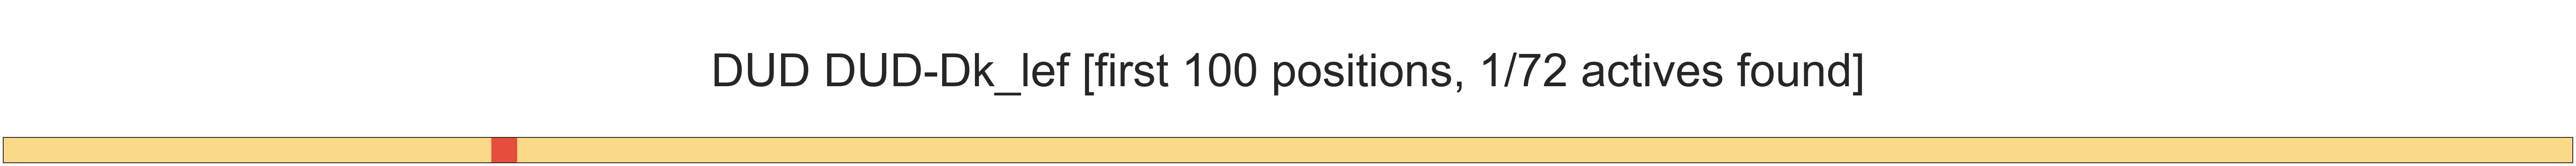

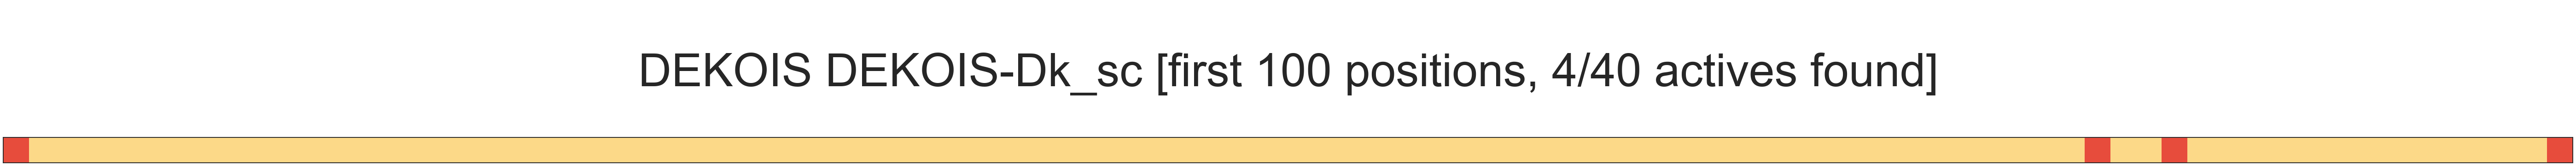

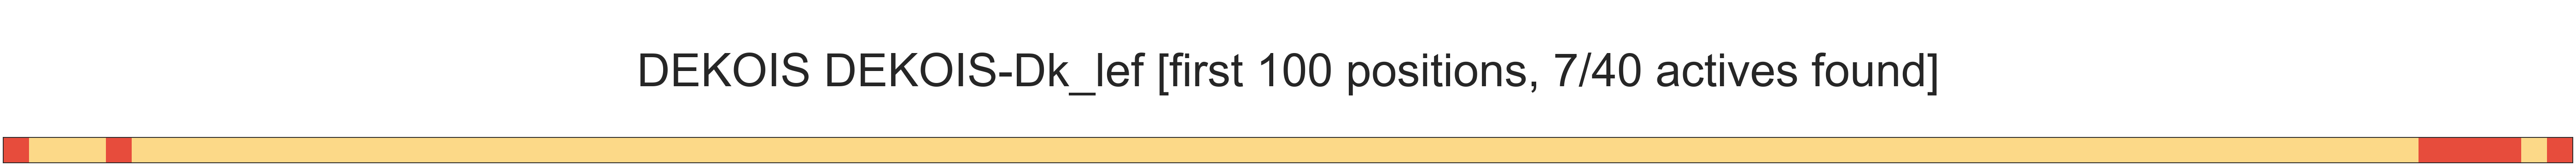

In [135]:
tree_params = {'criterion': ['gini'],
              'max_depth': [2, 3, 4, 5, 10, 20]}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
TREE = DecisionTreeClassifier
tree_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= TREE, estimator_params = tree_params)

# Parameters used
for name, model in tree_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
tree_clf_pred = eval_wrapper(trained_model = tree_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Decision Tree', predictions = tree_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

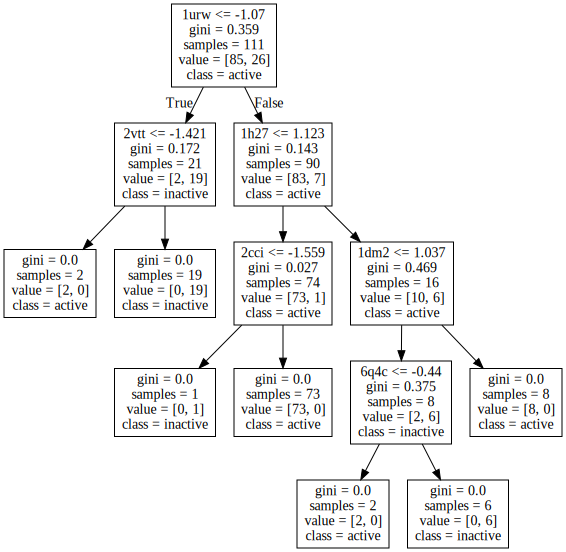

In [132]:
# Visualization
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

# Graph tree
feature_names = scores_dic['CSAR']['Dk_sc']['X'].columns
estimator = tree_clf['Dk_sc'].best_estimator_['estimator']
graph = Source(export_graphviz(estimator, 
                        out_file=None, feature_names = feature_names, 
                        class_names = ['active', 'inactive']))

display(SVG(graph.pipe(format='svg')))

## Random Forest Clasiffier

In [136]:
from sklearn.ensemble import RandomForestClassifier

Model for Dk_sc:
	Best parameters: {'estimator__max_depth': 10, 'estimator__n_estimators': 20}
	Train set accuracy: 0.897
Model for Dk_lef:
	Best parameters: {'estimator__max_depth': 10, 'estimator__n_estimators': 20}
	Train set accuracy: 0.841


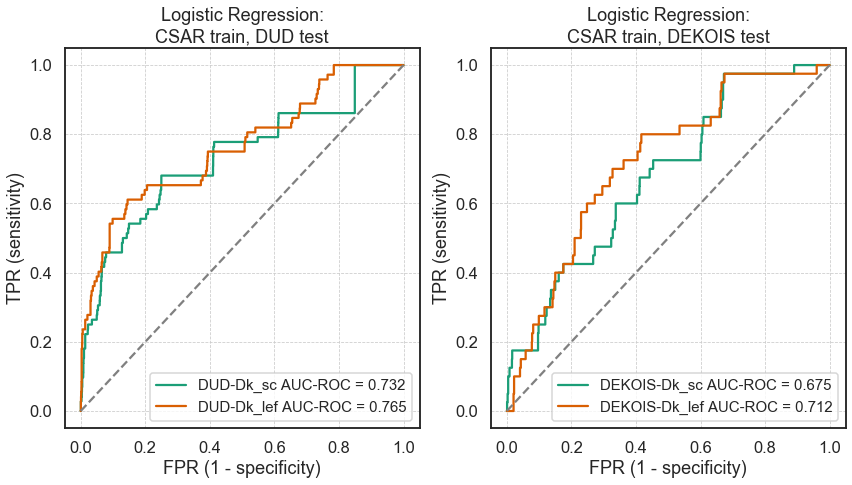

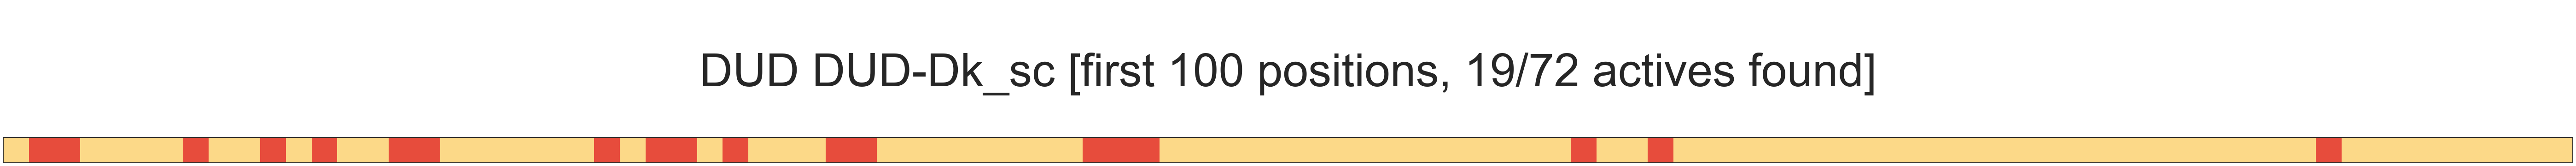

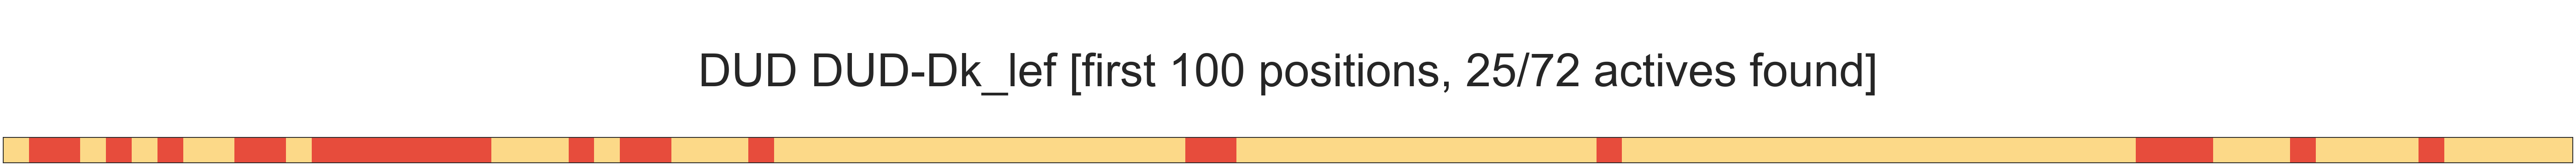

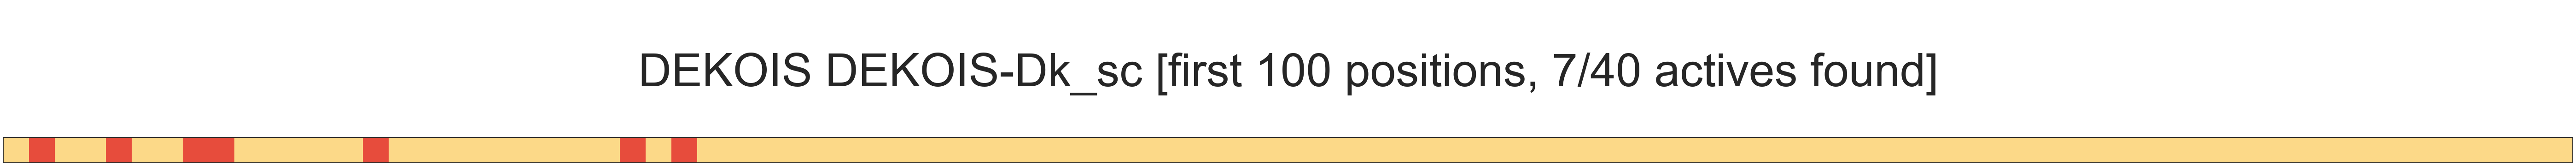

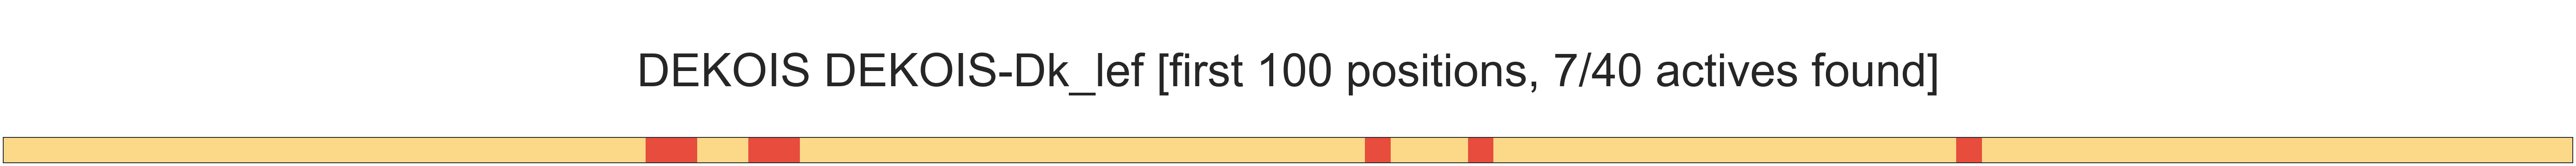

In [156]:
rf_params = {'n_estimators': [20],
             'max_depth': [10]}

list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
RF = RandomForestClassifier
rf_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                       estimator_params = rf_params,
                       estimator= RF, n_jobs = -1)

# Parameters used
for name, model in rf_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
rf_clf_pred = eval_wrapper(trained_model = rf_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Logistic Regression', predictions = rf_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)